In [1]:
# Standard library imports
import random

# Dependencies
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal
from spectrum import aryule, arma2psd
from astropy import units as u
from astropy.timeseries.periodograms import LombScargle

# Local imports
from tapify import MultiTaper

# Test MultiTaper using sinusoidal data

## Test Case 1: Evenly-sampled sinusoidal data

The following test case generates sinusoidal data ``x`` on an evenly sampled grid of observation times ``t``, and computes the `MultiTaper` Periodogram. In the case of evenly-sampled data, `MultiTaper` uses the Fast Fourier Transform (FFT) algorithm to efficiently compute the Discrete Fourier Transform of the tapered data. We then compare the `MultiTaper` Periodogram with the Classical Periodogram which uses FFT on untapered data.

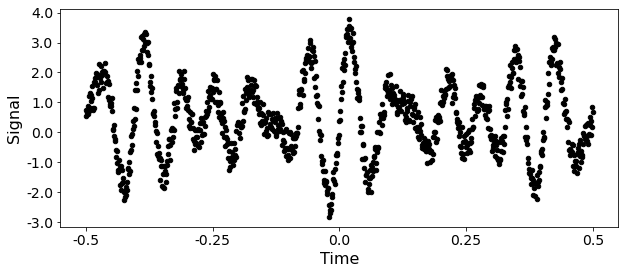

In [2]:
# Random number generator
rng = np.random.RandomState(0)

# Evenly-spaced time
t_even = np.linspace(-0.5, 0.5, 1000)

# Tau represents full circle!
tau = 2*np.pi
# Generate sinusoidal signal
x_even = np.sin(10*tau*t_even) + np.sin(12*tau*t_even) \
           + np.sin(15*tau*t_even) + 1*rng.rand(t_even.shape[0])

# Plot the signal
plt.figure(figsize=(10, 4))
plt.scatter(t_even, x_even, color='black', s=20)
plt.xticks(np.linspace(-0.5, 0.5, 5), np.linspace(-0.5, 0.5, 5),
           fontsize=14)
plt.yticks(np.linspace(-3, 4, 8), np.linspace(-3, 4, 8), fontsize=14)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Signal', fontsize=16)
plt.show()

`MultiTaper` Periodogram with `NW=1` and `K=1` uses the first DPSS taper, which has the least spectral leakage, as the data window to generate a single-taper periodogram.

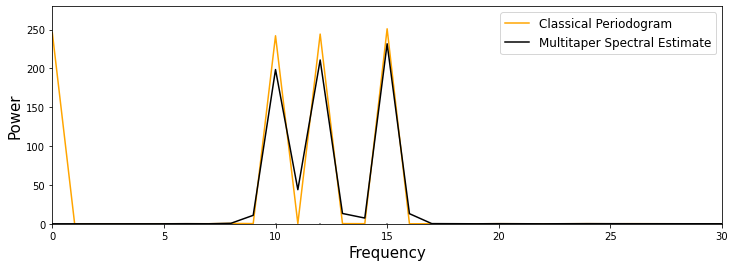

In [3]:
# Total time duration
T = t_even[-1] - t_even[0]
# Number of samples
N = t_even.shape[0]
# Sampling time
delta_t = T/N
# Sampling frequency
fs = 1/(delta_t)

# Classical Periodogram frequency and power
freq = fftfreq(N, delta_t)[:N//2]
power = 1/N*np.abs(fft(x_even)[:N//2])**2

# Multitaper Periodogram frequency and power
mt_even = MultiTaper(x_even, t_even, NW=1, K=1)
freq_mt, power_mt = mt_even.periodogram(center_data=True, method='fft')

plt.figure(figsize=(12, 4))
plt.plot(freq, power, color='orange', label='Classical Periodogram')
plt.plot(freq_mt, power_mt, color='black', label='Multitaper Spectral Estimate')
plt.vlines([10, 12, 15], 0, 0.8, linestyle='--', color='grey')
plt.xlim([0, 30])
plt.ylim([0, 280])
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.legend(fontsize=12)

## Test Case 2: Evenly-sampled AR(4) data

The following test case simulates time-series data using an autoregressive (AR) process.

It is denoted as:

$X_t = c + \sum_{i=1}^{p} \Psi_i X_{t-i} + \epsilon_t$

where p = 4 represents the order of the AR process.

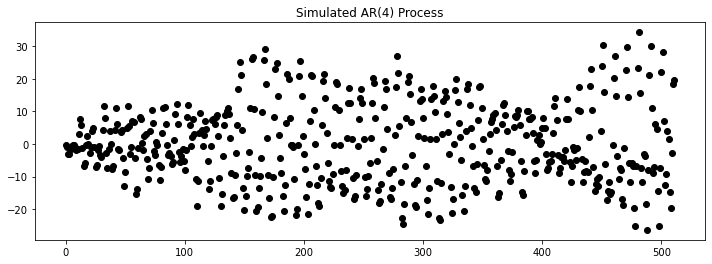

In [28]:
# Set seed
rng.seed(2)

# Simulate AR(4) data
ar4 = np.array([1, -2.2137, 2.9403, -2.1697, 0.9606])
y = signal.lfilter([1], ar4, rng.randn(1, 512))
N = len(y[0])

# Plot signal
plt.figure(figsize=[12, 4]); # Set dimensions for figure
plt.scatter(np.arange(N), y[0], color='black')
plt.title("Simulated AR(4) Process")
plt.show()

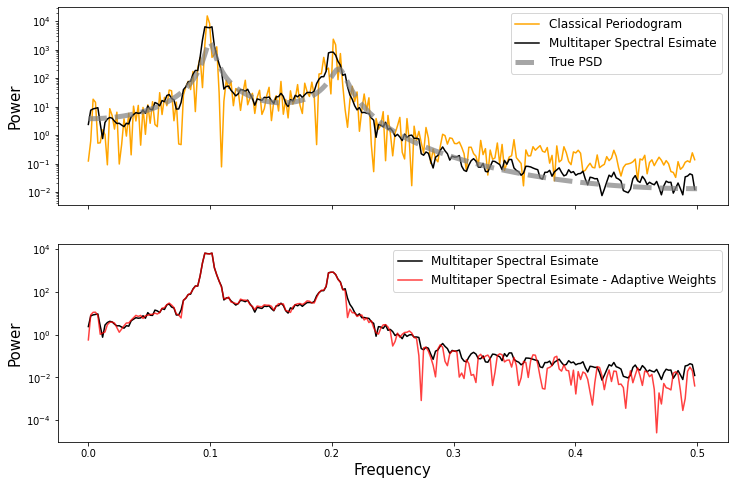

In [190]:
# True Power Spectral Density (PSD)
AR, P, k = aryule(y[0], 4)
PSD = arma2psd(AR, NFFT=N)
PSD = PSD[:N//2]

# Classical Periodogram
freq = fftfreq(N, 1)[:N//2]
power = 1/N*np.abs(fft(y[0])[:N//2])**2

# MultiTaper Periodogram
mt_even = MultiTaper(y[0], delta_t=1, NW=2.5, K=4)
freq_mt, power_mt = mt_even.periodogram(center_data=True, method='fft',
                                        adaptive_weighting=False)
freq_mt_aw, power_mt_aw = mt_even.periodogram(center_data=True, method='fft',
                                              adaptive_weighting=True)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
ax[0].plot(freq, power, color='orange', label='Classical Periodogram')
ax[0].plot(freq_mt, power_mt, color='black', label='Multitaper Spectral Esimate')
ax[0].plot(np.linspace(0, 0.5, len(PSD)), PSD, color='grey', linestyle='dashed',
           linewidth=5, alpha=0.7, label='True PSD')
ax[0].set_yscale('log')
ax[0].set_ylabel('Power', fontsize=15)
ax[0].legend(fontsize=12)

ax[1].plot(freq_mt, power_mt, color='black', label='Multitaper Spectral Esimate')
ax[1].plot(freq_mt_aw, 4*power_mt_aw, color='red', alpha=0.75, label='Multitaper Spectral Esimate - Adaptive Weights')
ax[1].set_yscale('log')
ax[1].set_ylabel('Power', fontsize=15)
ax[1].set_xlabel('Frequency', fontsize=15)
ax[1].legend(fontsize=12)


The top panel shows that `MultiTaper` is able to reduce bias in the high frequencies while also reducing variance. The bottom panel compares `MultiTaper` Spectral Estimate with and without adaptive weighting. Adpative weighting uses smaller weights for higher order tapers producing periodograms with low spectral leakage at the cost of higher variance. The advantage of doing that is that you can choose a high number of tapers, and leave optimization to the weighting.

## Test Case 3: Unevenly-sampled sinusoidal data

The following test case generates sinusoidal data ``x`` at unevenly-sampled times ``t``, and computes the `MultiTaper` Periodogram. In the case of unevenly-sampled data, the Lomb-Scargle Periodogram can be applied on tapered data to compute the `MultiTaper Lomb Scargle`. In addition, a Non-Uniform Discrete Fourier Transform (or the efficient Non-Uniform Fast Fourier Transform (NUFFT)) can be applied on tapered data to compute the classical periodogram on tapered data. 

We compare the `MultiTaper Lomb Scargle`, `MultiTaper NUDFT` and `MultiTaper NUFFT` Periodogram with the standard Lomb-Scargle Periodogram

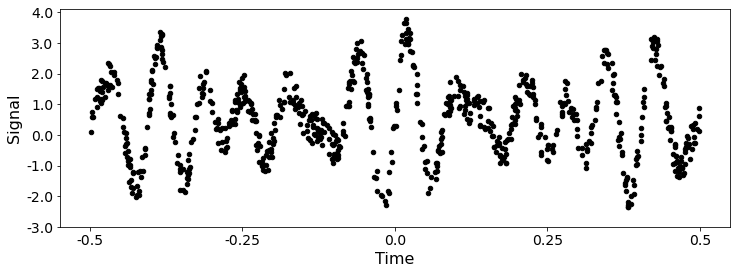

In [135]:
# Uneven-time samples
# Time ranges from -1/2 to 1/2
rng.seed(0)
t_uneven = -0.5 + rng.rand(800)
t_uneven = np.sort(t_uneven)

# Generate sinusoidal data
x_uneven = np.sin(10*tau*t_uneven) + np.sin(12*tau*t_uneven) \
           + np.sin(15*tau*t_uneven) + 1*rng.rand(t_uneven.shape[0])

# Plot signal
plt.figure(figsize=(12, 4))
plt.scatter(t_uneven, x_uneven, color='black', s=20)
plt.xticks(np.linspace(-0.5, 0.5, 5), np.linspace(-0.5, 0.5, 5),
           fontsize=14)
plt.yticks(np.linspace(-3, 4, 8), np.linspace(-3, 4, 8), fontsize=14)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Signal', fontsize=16)
plt.show()

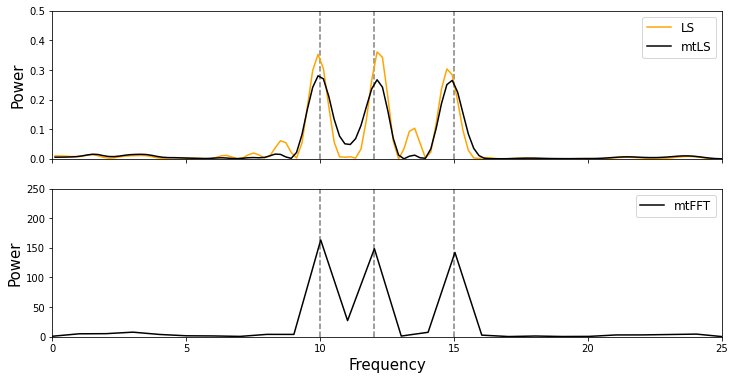

In [136]:
# Apply LS, MTLS (NW=1, K=1), MTFFT (NW=1, K=1) and compare
freq, power = LombScargle(t_uneven, x_uneven).autopower(nyquist_factor=1)

mt_uneven_ls = MultiTaper(x_uneven, t_uneven, NW=1, K=1)
freq_mtls, power_mtls = mt_uneven_ls.periodogram(center_data=True, method='LS',
                                                 adaptive_weighting=False,
                                                 nyquist_factor=1)

mt_uneven_fft = MultiTaper(x_uneven, t_uneven, NW=1, K=1)
freq_mtfft, power_mtfft = mt_uneven_fft.periodogram(center_data=True, method='fft',
                                                    adaptive_weighting=False,
                                                    nyquist_factor=1)

# Compare LS and MTLS
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(12, 6))
ax[0].plot(freq, power, color='orange', label='LS')
ax[0].plot(freq_mtls, power_mtls, color='black', label='mtLS')
ax[0].vlines([10, 12, 15], 0, 0.5, linestyle='--', color='grey')
ax[0].set_ylim([0, 0.5])
ax[0].set_ylabel('Power', fontsize=15)
ax[0].legend(fontsize=12)

# MTFFT is plotted separately due to different normalization
ax[1].plot(freq_mtfft, power_mtfft, color='black', label='mtFFT')
ax[1].vlines([10, 12, 15], 0, 250, linestyle='--', color='grey')
ax[1].set_ylim([0, 250])
ax[1].set_ylabel('Power', fontsize=15)
ax[1].set_xlim([0, 25])
ax[1].set_xlabel('Frequency', fontsize=15)
ax[1].legend(fontsize=12)

### F-test

The F statistic measures how purely periodic a signal is in the presence coloured noise as follows:

$F(f) = (K-1) * var_{f}/var_{noise}$

where $var_{f}$ quantifies the presence of the sinusoidal signal $f$, $var_{noise}$ quantifies the residual noise, and $K$ = number of tapers. The F test uses eigencoefficients to the variances; it thus uses phase information hidden in the DFT.

We apply the F-test on the above unevenly-sampled sinusoidal data.

In [137]:
mt = MultiTaper(x_uneven, t_uneven, NW=2, K=3)

In [138]:
# Apply F-test to the signal using either DFT (slow) or FFT (fast)
freq, f_test_dft = mt.ftest(center_data=True, method='dft')
freq, f_test_fft = mt.ftest(center_data=True, method='fft')

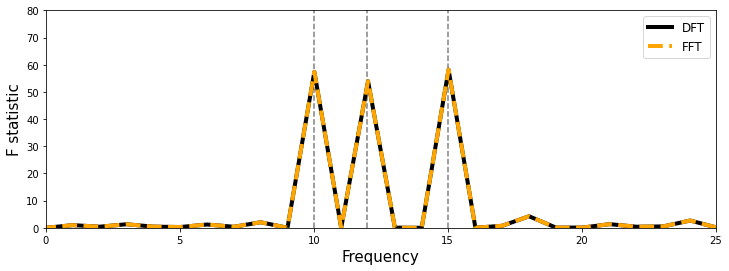

In [140]:
# Compare the two F statistics
plt.figure(figsize=(12, 4))
plt.plot(freq, f_test_dft, color='black', label='DFT', linewidth=4)
plt.plot(freq, f_test_fft, color='orange', label='FFT', linestyle='dashed', linewidth=4)
plt.vlines([10, 12, 15], 0, 80, linestyle='--', color='grey')
plt.xlim([0, 25])
plt.ylim([0, 80])
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('F statistic', fontsize=15)
plt.legend(fontsize=12)